In [42]:
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
from numpy import linalg as LA
import pandas as pd
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from scipy.sparse import csgraph

In [43]:
def get_nodes(data_file):
    data = pd.read_csv(data_file, sep = ' ', header = None)
    left_nodes = data[0].values
    right_nodes = data[1].values
    combined_nodes = np.concatenate((left_nodes, right_nodes), axis = 0)
    combined_nodes = np.unique(combined_nodes)
    
    return left_nodes, right_nodes, combined_nodes

In [44]:
def get_unique(arr):
    unique = []
    for i in arr:
        if i not in unique:
            unique.append(i)
    return unique

In [45]:
def get_graph(combined_nodes, left_nodes, right_nodes):
    neighbors = []
    graph = {}
    
    for node in combined_nodes:
        if node in left_nodes:
            indices = np.where(left_nodes == node)
            for index in indices:
                neighbors.append(right_nodes[index])
        if node in right_nodes:
            indices = np.where(right_nodes == node)
            for index in indices:
                neighbors.append(left_nodes[index])

        unique_neighbors = get_unique(neighbors[0])

        unique_neighbors = np.array(unique_neighbors)
        graph[node] = unique_neighbors
        neighbors = []
    
    return graph

In [46]:
def get_adjacency_matrix(graph):
    adjacency_matrix = np.zeros([len(graph), len(graph)])

    for key, value in graph.items():
        for neighbor in value:
            adjacency_matrix[key][value] = 1
    
    return np.array(adjacency_matrix)

In [47]:
def get_degree_matrix(adjacency_matrix):
    degree_matrix = np.zeros([len(adjacency_matrix), len(adjacency_matrix)])
    
    for row_index in range(len(adjacency_matrix)):
        degree_matrix[row_index][row_index] = np.sum(adjacency_matrix[row_index])

    return degree_matrix

In [48]:
def get_laplacian_matrix(adjacency_matrix, degree_matrix):
    laplacian_matrix = np.subtract(degree_matrix, adjacency_matrix)
    return laplacian_matrix

In [49]:
def get_eigen(laplacian_matrix):
    eig_values, eig_vectors = LA.eig(laplacian_matrix)
    return eig_values, eig_vectors

In [50]:
def least_significat_eigens(k, eig_values, eig_vectors):
    idx = eig_values.argsort()[:k]
    eig_vectors = eig_vectors[:, idx]
    eig_values = eig_values[idx]
    
    return eig_vectors, eig_values

In [51]:
# Use L1 normalization
def normalize_vectors(least_vectors):
    least_vectors_norm = normalize(
        least_vectors, 
        norm = 'l1'
    )
    return least_vectors_norm

In [52]:
# Visualize least significant eigenvalues
def visualize_eigenvalues(least_values):
    plt.plot(least_values)
    plt.title('Least significant eigenvelues')
    plt.show()

In [53]:
# Visualize least significant eigenvectors
def visualize_eigenvectors(least_vectors):
    plt.rcParams["figure.figsize"] = (10, 7)

    for i in range(least_vectors.shape[1]):
        plt.plot(least_vectors[:][i], label= str(i))

    plt.legend(loc='upper right')
    plt.title('Least significant eigenvectors')
    plt.show()

In [54]:
def cluster_graph(k, least_vectors):
    kmeans = KMeans(
        n_clusters = k, 
        random_state = 0
    )
    
    kmeans.fit(least_vectors)
    
    return kmeans

In [55]:
# Visualize cluster distribution
def visualize_class_distribution(k, kmeans):
    distribution = []
    clusters = np.arange(0, k)

    for cluster in range(k):

        elements = np.where(kmeans.labels_ == cluster)[0]
        elements = len(elements)
        distribution.append(elements)

    plt.bar(clusters, distribution)
    plt.xticks(clusters)
    plt.xlabel('number of clusters')
    plt.ylabel('number of elements')
    plt.title('Cluster distribution')
    plt.show()

In [56]:
def save_output(combined_nodes, kmeans, file_name):
    df = pd.DataFrame({'node' : combined_nodes, 'cluster' : kmeans.labels_})
    df = df[['node', 'cluster']]
    df.to_csv(os.path.join('output', file_name.split('.')[0] + '.output'), index = False, sep = ' ')

In [57]:
def main(k, file_name):
    
    data_file = os.path.join('data', file_name)
   
    left_nodes, right_nodes, combined_nodes = get_nodes(data_file)
    
    graph = get_graph(combined_nodes, left_nodes, right_nodes)
    adjacency_matrix = get_adjacency_matrix(graph)
    
    if file_name == 'ca-GrQc.txt':
        degree_matrix = get_degree_matrix(adjacency_matrix)
        laplacian_matrix = get_laplacian_matrix(adjacency_matrix, degree_matrix)
    else:
        laplacian_matrix = csgraph.laplacian(adjacency_matrix, normed=True)
    
    eig_values, eig_vectors = get_eigen(laplacian_matrix)
    
    least_vectors, least_values = least_significat_eigens(k, eig_values, eig_vectors)
    least_values = least_values.real
    least_vectors = least_vectors.real
    
    if file_name !='ca-GrQc.txt':
        least_vectors = normalize_vectors(least_vectors)
    
    visualize_eigenvalues(least_values)
    visualize_eigenvectors(least_vectors)
    
    kmeans = cluster_graph(k, least_vectors)
    
    visualize_class_distribution(k, kmeans)
    
    save_output(combined_nodes, kmeans, file_name)

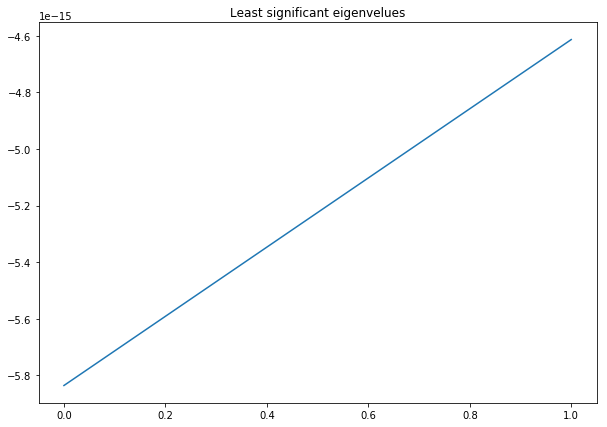

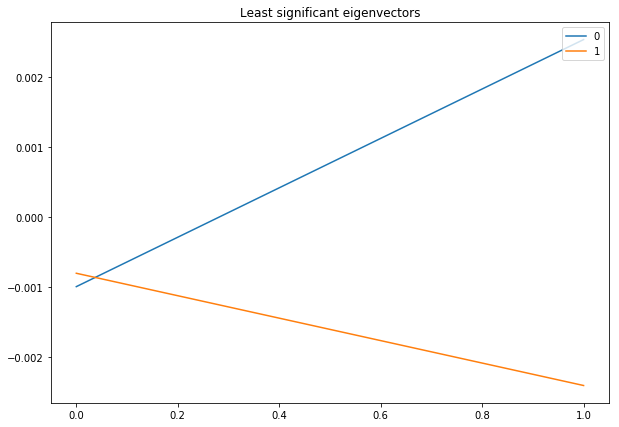

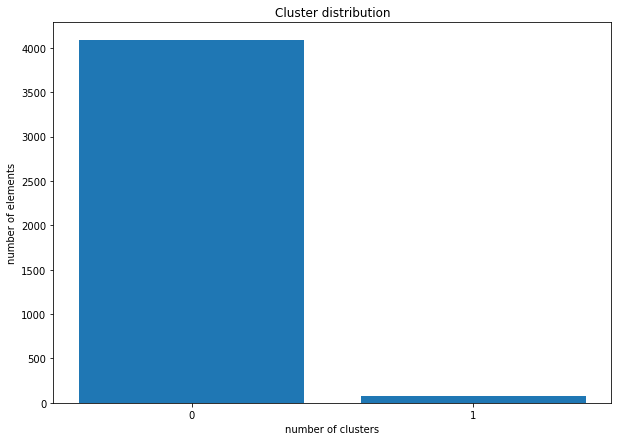

In [58]:
k = 2
file_array = ['ca-AstroPh.txt', 'ca-CondMat.txt', 'ca-GrQc.txt', 'ca-HepPh.txt', 'ca-HepTh.txt']
file_name = file_array[2]


main(k, file_name)